## Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Loading

In [3]:
def load_variants_and_summaries(folder: os.PathLike) -> pd.DataFrame:
    dfs = []
    for root, _, filenames in os.walk(folder):
        for filename in filenames:
            if filename.endswith('.evo'):
                filepath = os.path.join(root, filename)
                variant = os.path.dirname(filepath)[len(folder)+1:]
                df = pd.read_csv(filepath, sep='\t')
                df = df.set_index('generation_id')
                dfs.append((variant, df))
    return dict(dfs)

In [4]:
summary_per_variant = load_variants_and_summaries(folder='../evolution')

In [5]:
[(k, len(v)) for (k, v) in summary_per_variant.items()]

[('atavism=0.25/pmr=0.1/pma=-0.05', 99),
 ('atavism=0.25/pmr=0.1/pma=0.05', 99),
 ('atavism=0.25/pmr=0.1/pma=0.15', 99),
 ('atavism=0.25/pmr=0.1/pma=-0.15', 99),
 ('atavism=0.25/pmr=0.25/pma=-0.05', 99),
 ('atavism=0.25/pmr=0.25/pma=0.05', 99),
 ('atavism=0.25/pmr=0.25/pma=0.15', 99),
 ('atavism=0.25/pmr=0.25/pma=-0.15', 99),
 ('atavism=0.1/pmr=0.1/pma=-0.05', 99),
 ('atavism=0.1/pmr=0.1/pma=0.05', 99),
 ('atavism=0.1/pmr=0.1/pma=0.15', 99),
 ('atavism=0.1/pmr=0.1/pma=-0.15', 99),
 ('atavism=0.1/pmr=0.25/pma=-0.05', 99),
 ('atavism=0.1/pmr=0.25/pma=0.05', 99),
 ('atavism=0.1/pmr=0.25/pma=0.15', 99),
 ('atavism=0.1/pmr=0.25/pma=-0.15', 99),
 ('atavism=0.0/pmr=0.1/pma=-0.05', 99),
 ('atavism=0.0/pmr=0.1/pma=0.05', 99),
 ('atavism=0.0/pmr=0.1/pma=0.15', 99),
 ('atavism=0.0/pmr=0.1/pma=-0.15', 99),
 ('atavism=0.0/pmr=0.25/pma=-0.05', 99),
 ('atavism=0.0/pmr=0.25/pma=0.05', 99),
 ('atavism=0.0/pmr=0.25/pma=0.15', 99),
 ('atavism=0.0/pmr=0.25/pma=-0.15', 99)]

# Atavistm at 0%

In [6]:
def pool_series(ticks, values, fn):
    out = []
    prev_i = 0
    for i in ticks:
        section = list(values[prev_i:i])
        value = fn(section)
        out.append(value)
        prev_i = i
    return out

def max_pool_series(ticks, values):
    return pool_series(ticks, values, np.max)

def mean_pool_series(ticks, values):
    return pool_series(ticks, values, np.mean)

## Genetic Material over Generations

In [7]:
def plot_genetic_material_over_generations(df: pd.DataFrame, figlen: int = 8):
    
    def annotated_area(ax, ticks, values: pd.Series, color: str, label: str):
        values = mean_pool_series(ticks, values)
        ax.set_xticks(ticks)
        ax.fill_between(ticks, values, color=color, edgecolor='#fff', label=label)
        ax.plot(ticks, values, color="#ffffff", marker='o')

    def annotated_candles(ax, ticks, highs: pd.Series, lows: pd.Series, color: str, label: str):
        highs = mean_pool_series(ticks, highs)
        lows = mean_pool_series(ticks, lows)
        heights = [highs[i] - lows[i] for i in range(len(highs))]
        ax.set_xticks(ticks)
        ax.bar(ticks, height=heights, bottom=lows, width=2.5, color=color + 'cc', edgecolor=color, label=label)
        for i, h, l in zip(ticks, highs, lows):
            ax.text(i, h + 0.15, str(round(h, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))
            ax.text(i, l - 0.15, str(round(l, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))

    tickslen = len(df.index)
    ticksstep = max(1, int(tickslen / 15))
    ticks = np.arange(1, tickslen + 1, ticksstep)
    fig, ax = plt.subplots(figsize=(figlen, figlen/2))
    annotated_area(ax, ticks, df.entropy_dna_pool, color='#003f5c44', label='entropy (dna)')
    annotated_area(ax, ticks, df.entropy_fitness_scores, color='#58508d44', label='entropy (dna)')
    annotated_candles(ax, ticks, df.genes_max, df.genes_min, color='#bc5090', label='genes')
    ax.set_facecolor("#eee")
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=4)
    ax.grid(True)
    ax.set_xlabel('generation')
    ax.set_ylabel('gene counts & entropy score')
    fig.subplots_adjust(bottom=0.25)
    fig.tight_layout()

#plot_genetic_material_over_generations(df=summary_per_variant.get('tests'))

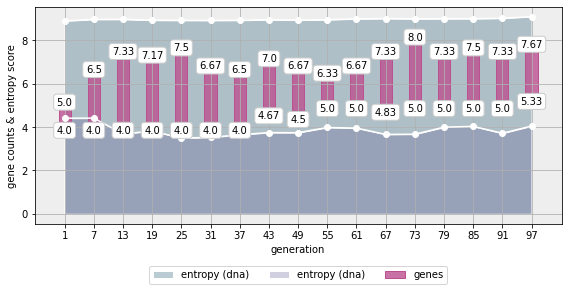

In [8]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.15'))

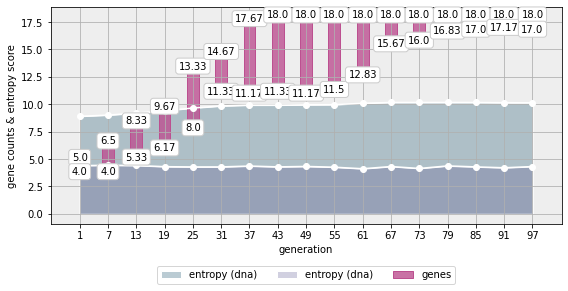

In [9]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.05'))

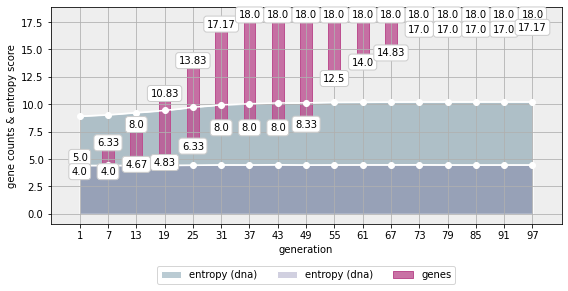

In [10]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.05'))

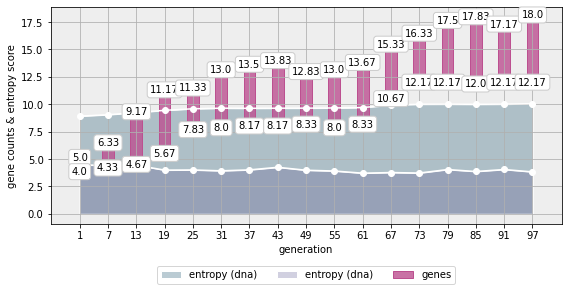

In [11]:
plot_genetic_material_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.15'))

## Fitness over Generations

In [12]:
def calculate_leap_series(highs: pd.Series) -> pd.Series:
    leaps = []
    highs = list(highs)
    highest = 0.
    for high in highs:
        leap = highest and high > highest
        leaps.append(1. if leap else 0.)
        highest = max(high, highest)
    return pd.Series(leaps)

In [13]:
def plot_fitness_over_generations(df: pd.DataFrame, figlen: int = 8, fitent_yadjust: int = 0, meanfit_yadjust: int = 0):
    from numpy import trapz
    def annotated_line(ax, ticks, values: pd.Series, color: str, label: str, ydist: float = None, pool_type: str = 'mean'):
        values = mean_pool_series(ticks, values) if pool_type else max_pool_series(ticks, values)
        ax.set_xticks(ticks)
        ax.plot(ticks, values, marker='o', color=color, label=label)
        ydist = max(values) * ydist
        for i, v in zip(ticks, values):
            ax.text(i, v + ydist, str(round(v, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="w", ec="#ccc", lw=1))
    def annotated_bar(ax, ticks, values: pd.Series, color: str, label: str, ydist: int):
        values = mean_pool_series(ticks, values)
        ax.set_xticks(ticks)
        ax.bar(ticks, height=values, color=color, edgecolor='#fff', width=5., label=label)
        for i, v in zip(ticks, values):
            ax.text(i, v + ydist, str(round(v, 2)), ha="center", va="center", bbox=dict(boxstyle="round", fc="#ffac00", ec="#ccc", lw=1))
    tickslen = len(df.index)
    ticksstep = max(1, int(tickslen / 15))
    ticks = np.arange(1, tickslen + 1, ticksstep)
    df['leaps'] = calculate_leap_series(df.fitness_highest)
    
    normalised_leaps = mean_pool_series(ticks, df.leaps)
    print(f"Total Leaps: {len(df[df.leaps > 0])}")
    print(f"AUC of Lel(k): {trapz(normalised_leaps)}")
    print(f"Highest Fitness Scores: {float(df.fitness_highest.max())}")
    print(f"Mean Entropy of DNA Pool: {float(df.entropy_dna_pool.mean())}")
    print(f"Mean Entropy of Fitness Scores: {float(df.entropy_fitness_scores.mean())}")

    fig, ax = plt.subplots(figsize=(figlen, figlen))
    ax.set_facecolor("#eee")
    ax.grid(True)
    ax.set_xlabel('generation')
    ax.set_ylabel('Lel(k)')
    annotated_bar(ax, ticks, df.leaps, color='#bc509044', label='Lel(k)', ydist=0.025 + fitent_yadjust)
    ax.legend(loc='lower right', bbox_to_anchor=(0.5, -0.125), ncol=4)
    
    ax2 = ax.twinx()
    ax2.set_ylabel('fitness score & entropy score')
    annotated_line(ax2, ticks, df.fitness_highest, color='#003f5c', label='fitness (highest)', ydist=0.025, pool_type='max')
    annotated_line(ax2, ticks, df.fitness_mean, color='#58508d', label='fitness (mean)', ydist=0.45 + meanfit_yadjust)
    ax2.legend(loc='lower left', bbox_to_anchor=(0.5, -0.125), ncol=4)
    
    fig.subplots_adjust(bottom=0.25)
    fig.tight_layout()

#plot_fitness_over_generations(df=summary_per_variant.get('tests'))

Total Leaps: 5
AUC of Lel(k): 0.8333333333333333
Highest Fitness Scores: 134.1111765223474
Mean Entropy of DNA Pool: 8.972697510904847
Mean Entropy of Fitness Scores: 3.8175872485937843


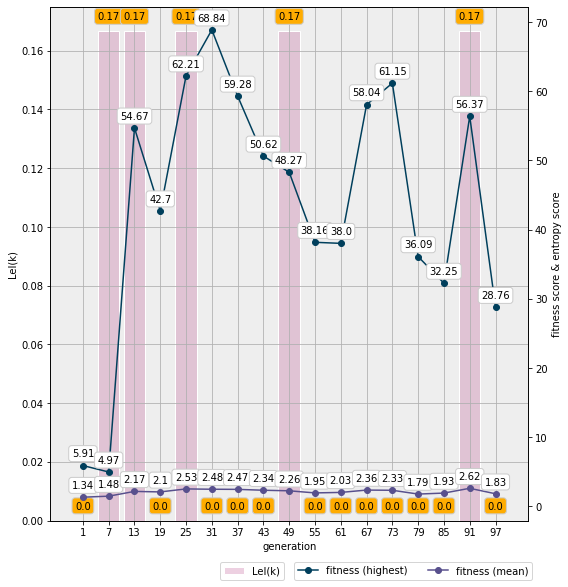

In [14]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.15'), fitent_yadjust=-0.02, meanfit_yadjust=0.2)

Total Leaps: 8
AUC of Lel(k): 1.3333333333333333
Highest Fitness Scores: 133.24032760487654
Mean Entropy of DNA Pool: 9.866898539440381
Mean Entropy of Fitness Scores: 4.300994933137583


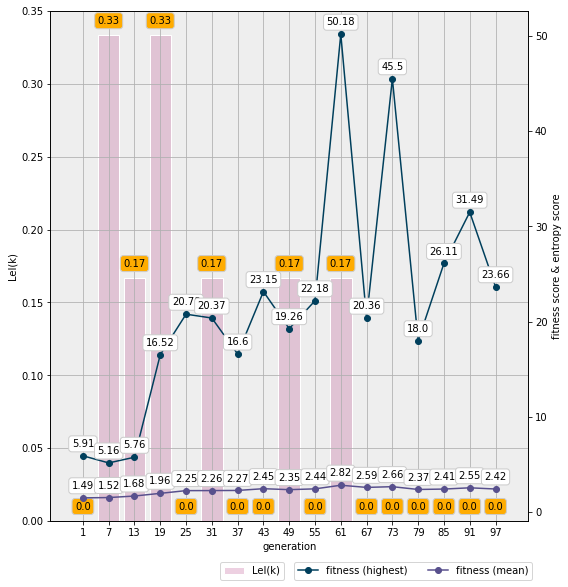

In [15]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=-0.05'), fitent_yadjust=-0.015)

Total Leaps: 4
AUC of Lel(k): 0.6666666666666666
Highest Fitness Scores: 10.054264550774306
Mean Entropy of DNA Pool: 9.956520260294274
Mean Entropy of Fitness Scores: 4.460218538351862


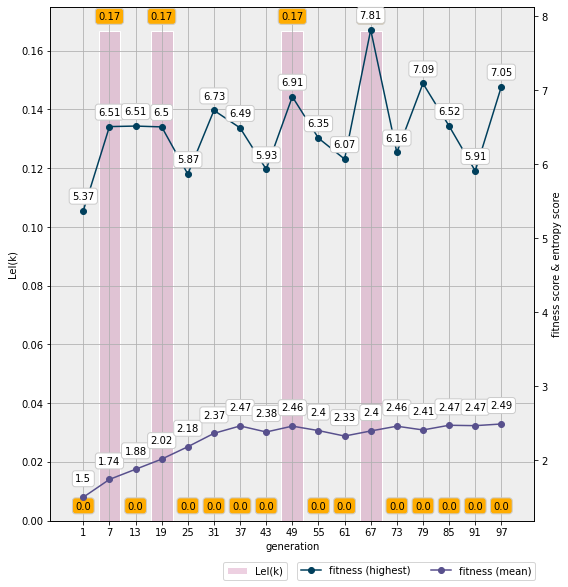

In [16]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.05'), fitent_yadjust=-0.02, meanfit_yadjust=-0.35)

Total Leaps: 9
AUC of Lel(k): 1.8333333333333333
Highest Fitness Scores: 156.68658734039008
Mean Entropy of DNA Pool: 9.702225864628119
Mean Entropy of Fitness Scores: 4.00305976172393


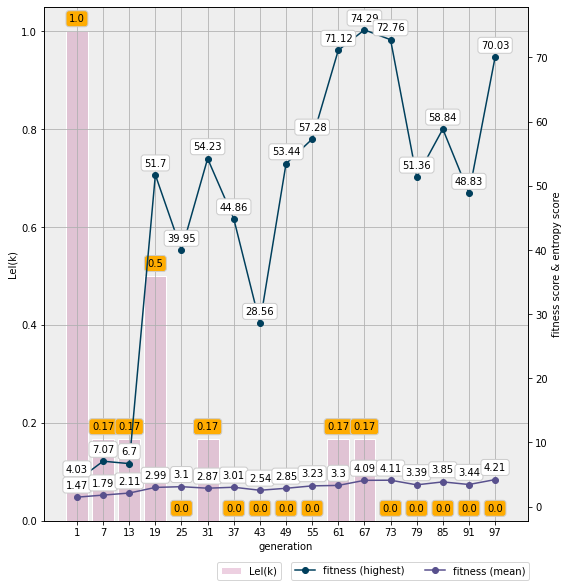

In [17]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.1/pma=0.15'))

Total Leaps: 8
AUC of Lel(k): 1.5833333333333335
Highest Fitness Scores: 135.22629676428204
Mean Entropy of DNA Pool: 9.031065542013227
Mean Entropy of Fitness Scores: 4.04505166823718


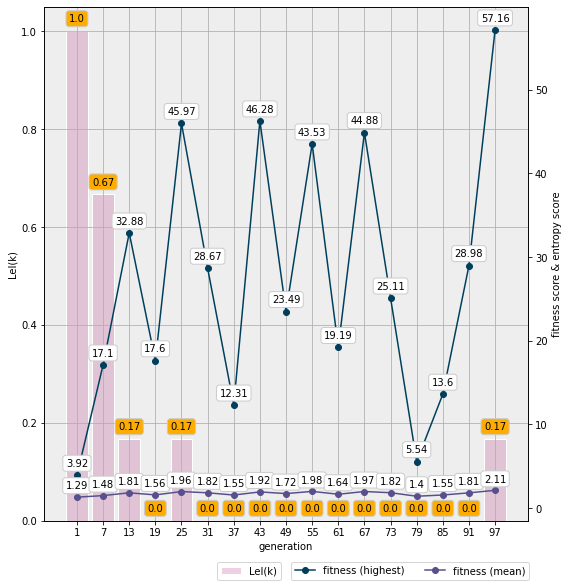

In [18]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=-0.15'), meanfit_yadjust=0.2)

Total Leaps: 5
AUC of Lel(k): 1.1666666666666665
Highest Fitness Scores: 126.72692323003196
Mean Entropy of DNA Pool: 9.375068612639833
Mean Entropy of Fitness Scores: 4.227680379943853


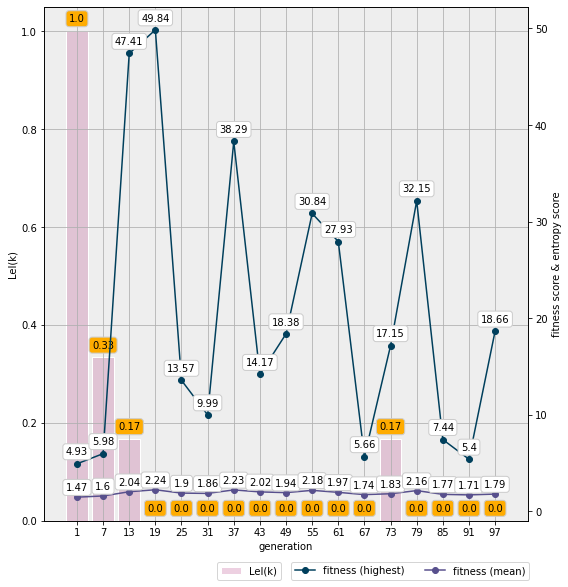

In [19]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=-0.05'))

Total Leaps: 5
AUC of Lel(k): 0.8333333333333333
Highest Fitness Scores: 9.317189451045056
Mean Entropy of DNA Pool: 9.925098736050648
Mean Entropy of Fitness Scores: 4.464928445783855


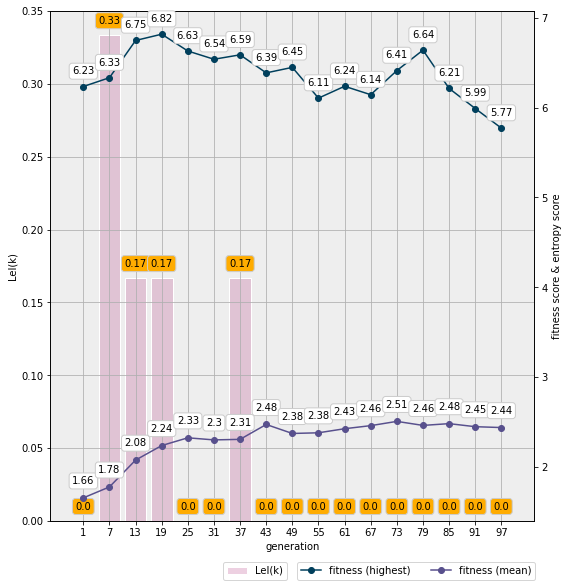

In [20]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=0.05'), fitent_yadjust=-0.015, meanfit_yadjust=-0.375)

Total Leaps: 1
AUC of Lel(k): 0.16666666666666666
Highest Fitness Scores: 10.406126426856178
Mean Entropy of DNA Pool: 9.755185525206445
Mean Entropy of Fitness Scores: 4.458665762557558


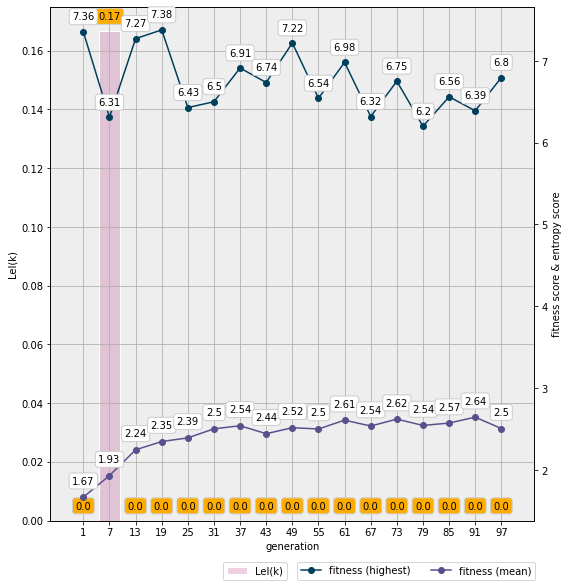

In [21]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.0/pmr=0.25/pma=0.15'), fitent_yadjust=-0.02, meanfit_yadjust=-0.375)

In [27]:
results_table = []
for key, df in summary_per_variant.items():
    if key.startswith('atavism=0.0/'):
        results_table.append({
            'name': key,
            'mean(fintess_mean)': float(df.fitness_mean.mean()),
            'max(fitness_hightest)': float(df.fitness_highest.max())
        })
pd.DataFrame(results_table).set_index('name').sort_index()

,mean(fintess_mean),max(fitness_hightest)
name,,
atavism=0.0/pmr=0.1/pma=-0.05,2.299040,133.240328
atavism=0.0/pmr=0.1/pma=-0.15,2.175308,134.111177
atavism=0.0/pmr=0.1/pma=0.05,2.303684,10.054265
atavism=0.0/pmr=0.1/pma=0.15,3.168485,156.686587
atavism=0.0/pmr=0.25/pma=-0.05,1.931560,126.726923
atavism=0.0/pmr=0.25/pma=-0.15,1.758801,135.226297
atavism=0.0/pmr=0.25/pma=0.05,2.338368,9.317189
atavism=0.0/pmr=0.25/pma=0.15,2.457528,10.406126


# Atavistm at 10%

Total Leaps: 5
AUC of Lel(k): 1.1666666666666667
Highest Fitness Scores: 114.6696928281704
Mean Entropy of DNA Pool: 9.489132512178331
Mean Entropy of Fitness Scores: 4.275883249551793


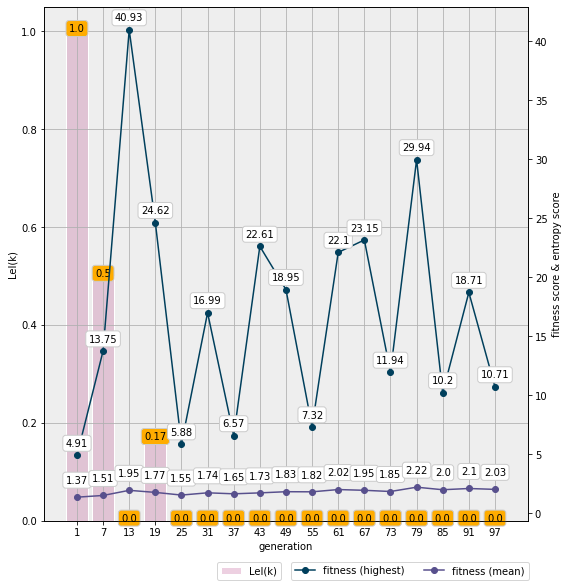

In [33]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.1/pma=-0.15'), fitent_yadjust=-0.02, meanfit_yadjust=0.2)

Total Leaps: 7
AUC of Lel(k): 1.5
Highest Fitness Scores: 100.17484360323976
Mean Entropy of DNA Pool: 9.783268679318743
Mean Entropy of Fitness Scores: 4.3725238196247


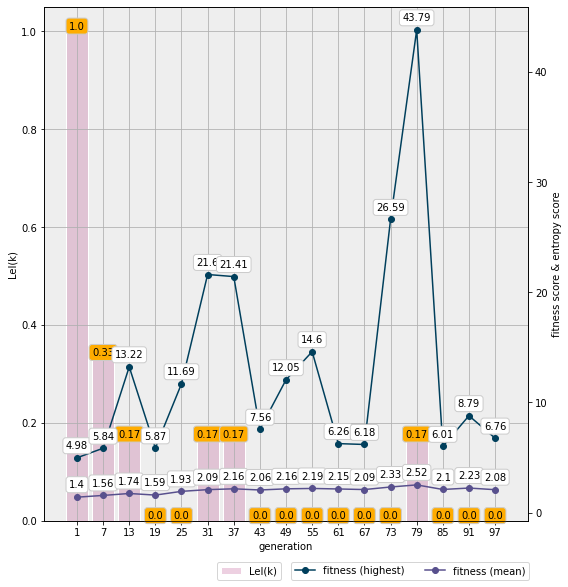

In [34]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.1/pma=-0.05'), fitent_yadjust=-0.015)

Total Leaps: 1
AUC of Lel(k): 0.16666666666666666
Highest Fitness Scores: 9.662033106963824
Mean Entropy of DNA Pool: 9.772652830280544
Mean Entropy of Fitness Scores: 4.449168681036868


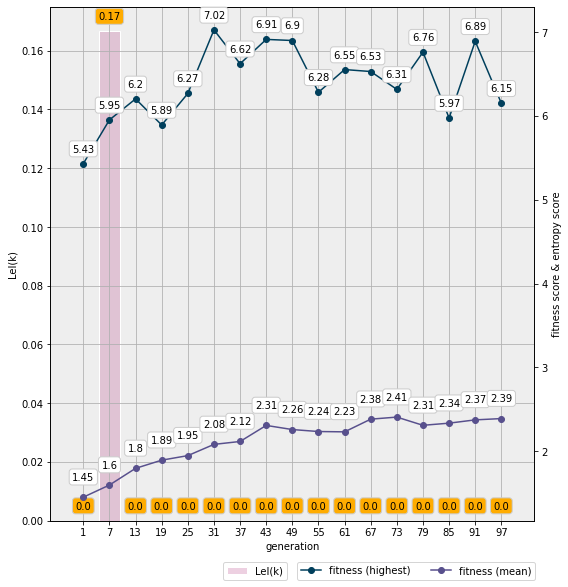

In [35]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.1/pma=0.05'), fitent_yadjust=-0.02, meanfit_yadjust=-0.35)

Total Leaps: 7
AUC of Lel(k): 1.1666666666666665
Highest Fitness Scores: 158.65378725985354
Mean Entropy of DNA Pool: 9.460110912016878
Mean Entropy of Fitness Scores: 3.9745673006052917


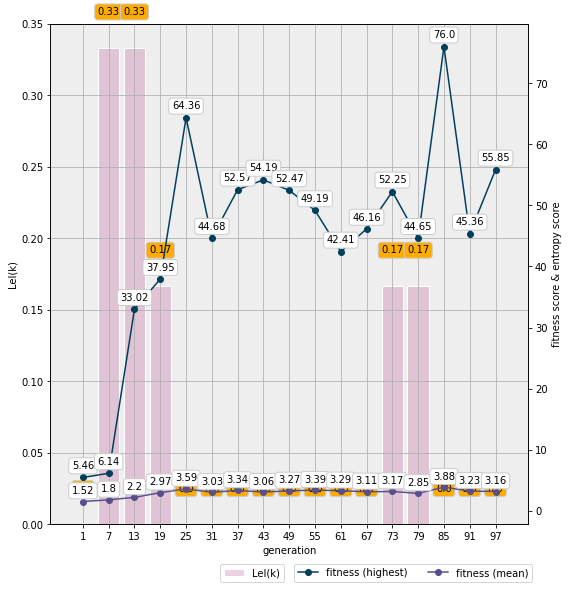

In [36]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.1/pma=0.15'))

Total Leaps: 4
AUC of Lel(k): 0.6666666666666666
Highest Fitness Scores: 938.6420474547408
Mean Entropy of DNA Pool: 9.254792267626309
Mean Entropy of Fitness Scores: 3.9645462566817695


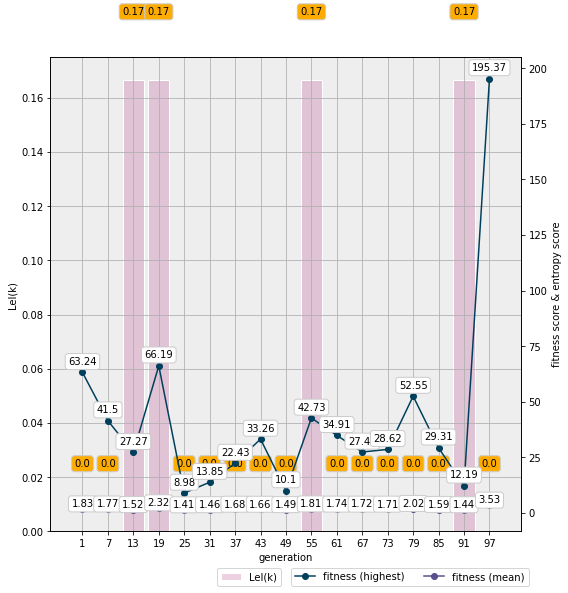

In [37]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.25/pma=-0.15'), meanfit_yadjust=0.2)

Total Leaps: 7
AUC of Lel(k): 1.4999999999999998
Highest Fitness Scores: 244.63959005736004
Mean Entropy of DNA Pool: 9.331338194145717
Mean Entropy of Fitness Scores: 3.9240942595921853


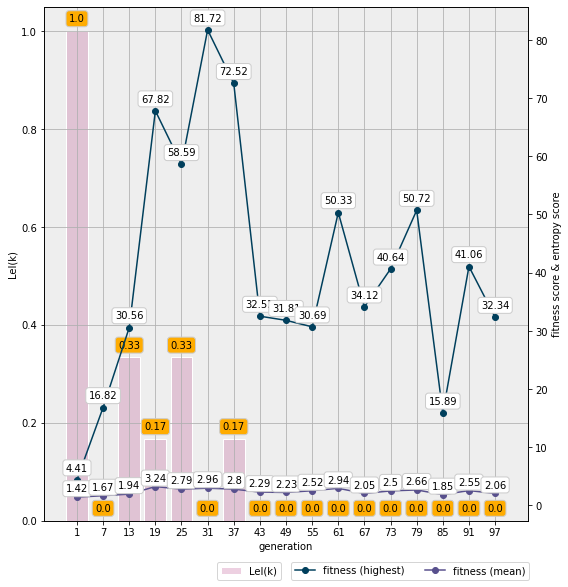

In [38]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.25/pma=-0.05'))

Total Leaps: 6
AUC of Lel(k): 1.3333333333333333
Highest Fitness Scores: 9.356002697537964
Mean Entropy of DNA Pool: 9.928777676251451
Mean Entropy of Fitness Scores: 4.458235627165753


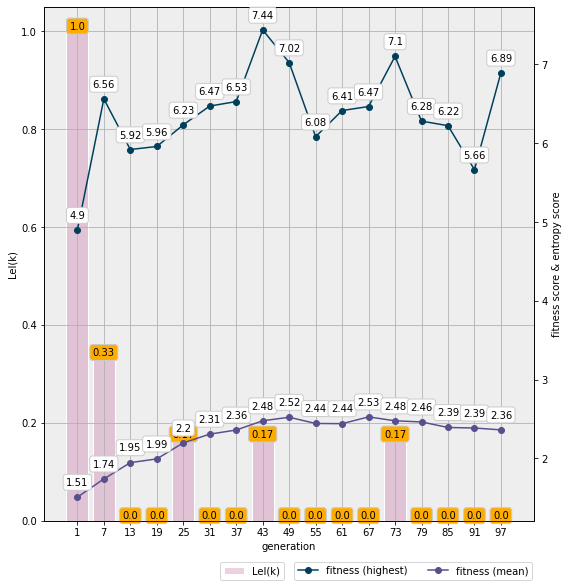

In [39]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.25/pma=0.05'), fitent_yadjust=-0.015, meanfit_yadjust=-0.375)

Total Leaps: 3
AUC of Lel(k): 0.8333333333333333
Highest Fitness Scores: 10.555797404984228
Mean Entropy of DNA Pool: 9.846614698755223
Mean Entropy of Fitness Scores: 4.460534670942312


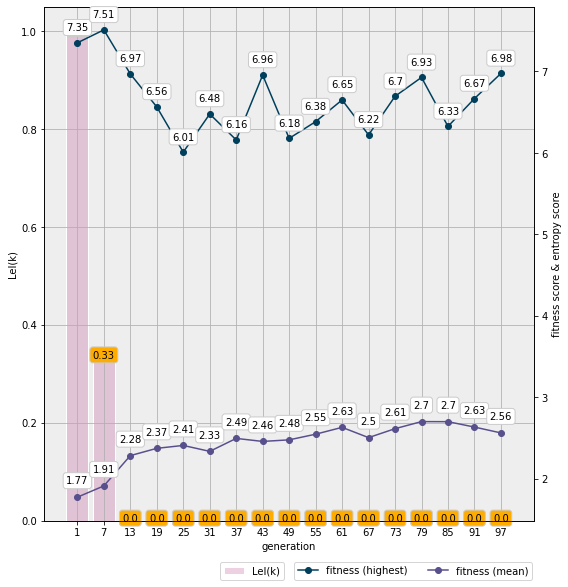

In [40]:
plot_fitness_over_generations(df=summary_per_variant.get('atavism=0.1/pmr=0.25/pma=0.15'), fitent_yadjust=-0.02, meanfit_yadjust=-0.375)

In [41]:
results_table = []
for key, df in summary_per_variant.items():
    if key.startswith('atavism=0.1/'):
        results_table.append({
            'name': key,
            'mean(fintess_mean)': float(df.fitness_mean.mean()),
            'max(fitness_hightest)': float(df.fitness_highest.max())
        })
pd.DataFrame(results_table).set_index('name').sort_index()

,mean(fintess_mean),max(fitness_hightest)
name,,
atavism=0.1/pmr=0.1/pma=-0.05,2.054153,100.174844
atavism=0.1/pmr=0.1/pma=-0.15,1.858116,114.669693
atavism=0.1/pmr=0.1/pma=0.05,2.160851,9.662033
atavism=0.1/pmr=0.1/pma=0.15,3.078798,158.653787
atavism=0.1/pmr=0.25/pma=-0.05,2.429296,244.639590
atavism=0.1/pmr=0.25/pma=-0.15,1.800170,938.642047
atavism=0.1/pmr=0.25/pma=0.05,2.308985,9.356003
atavism=0.1/pmr=0.25/pma=0.15,2.473254,10.555797
